In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.is_available()

True

In [3]:
from datetime import timedelta

In [4]:
from datetime import datetime

In [5]:
df_tr = pd.read_csv("kaggle_data/train.csv")

In [6]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

from datetime import datetime
def parse_time(x):

    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

In [7]:
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [8]:
outlier_threshold = 3
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

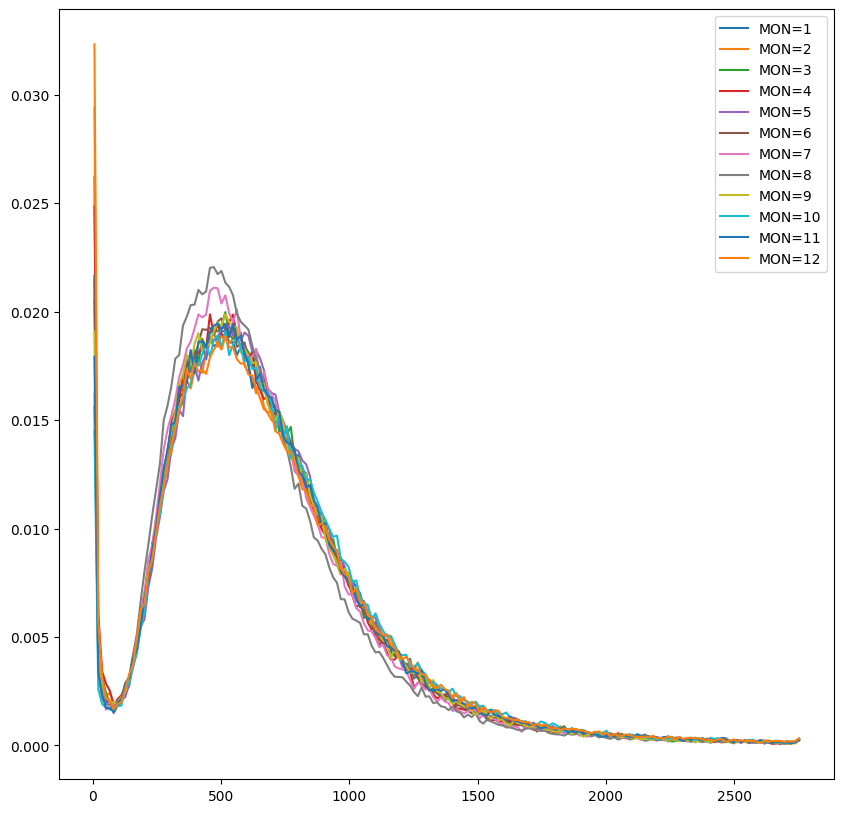

In [9]:
buckets = (int(mean + outlier_threshold * std) // 15)
plt.figure(figsize=(10,10))
for v in range(1,13):
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["MON"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"MON={v}")
plt.legend();

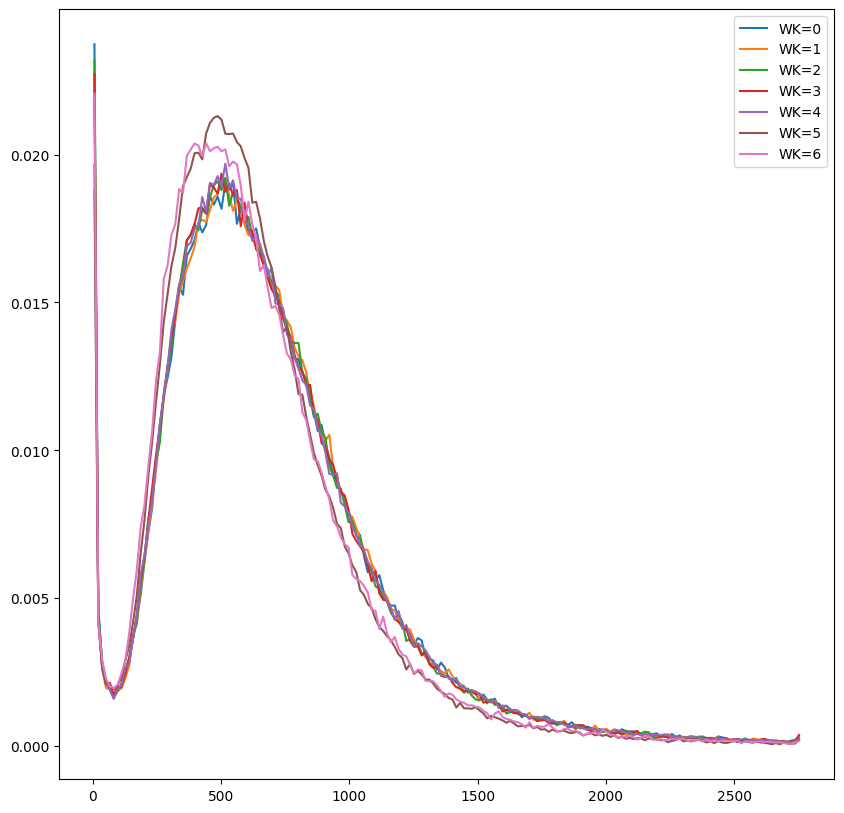

In [10]:
buckets = (int(mean + outlier_threshold * std) // 15)
plt.figure(figsize=(10,10))
for v in range(0,7):
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["WK"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"WK={v}")
plt.legend();

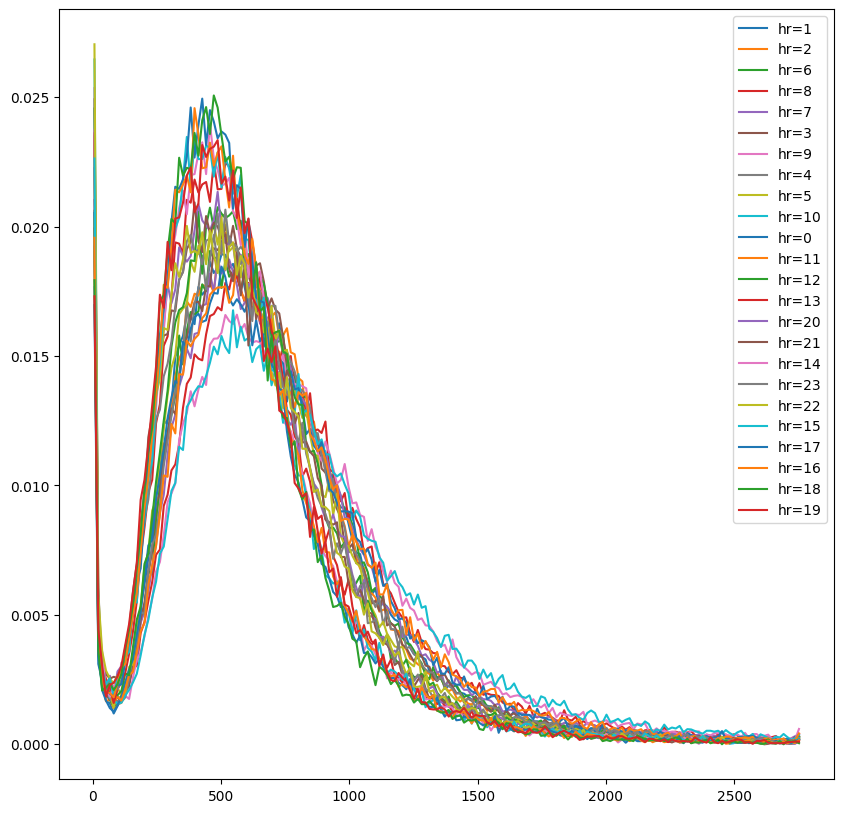

In [11]:
hrs = df_tr["HR"].value_counts().index
plt.figure(figsize=(10,10))
for v in hrs:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"hr={v}")
plt.legend();

In [12]:
values = df_tr['ORIGIN_CALL'].value_counts()>1000

In [13]:
ogcalls = df_tr['ORIGIN_CALL'].value_counts()[values].index

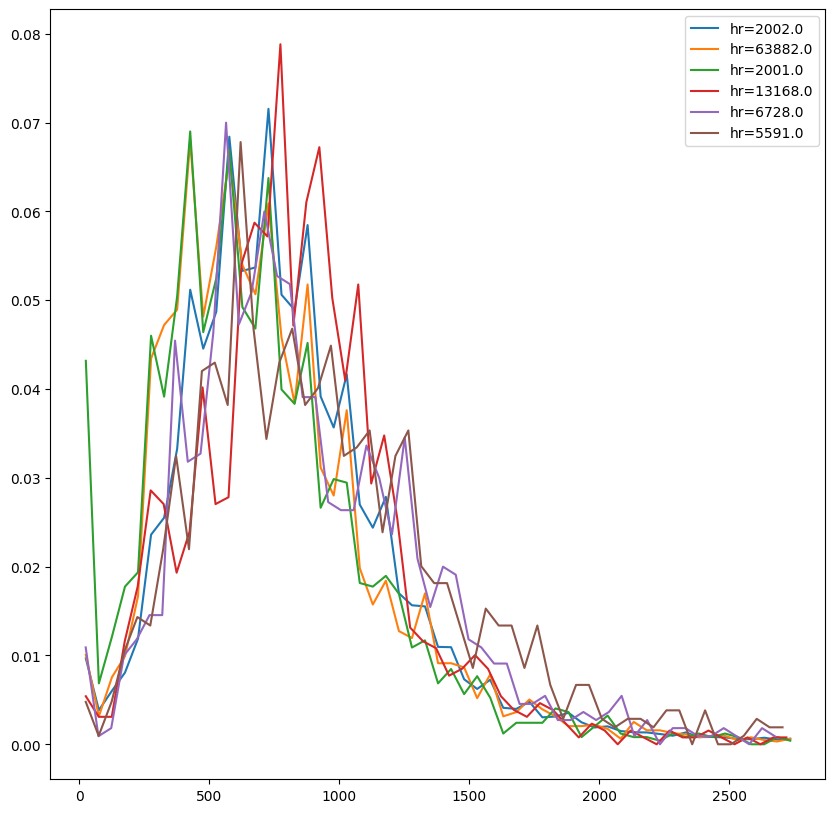

In [14]:
buckets = (int(mean + outlier_threshold * std) // 50)
plt.figure(figsize=(10,10))
for v in ogcalls:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["ORIGIN_CALL"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"hr={v}")
plt.legend();

In [15]:
sum(df_trimmed['TAXI_ID'].value_counts()>5000)

108

In [16]:
def ogin(x):
    if x in ogcalls:
        return True
    return False
df_trimmed["ORIGIN_CALL"].apply(ogin)

0          False
1          False
2          False
3          False
4          False
           ...  
1710665    False
1710666    False
1710667    False
1710668    False
1710669    False
Name: ORIGIN_CALL, Length: 1692771, dtype: bool

56990
6354
2478
1294
1100
1047


<ErrorbarContainer object of 3 artists>

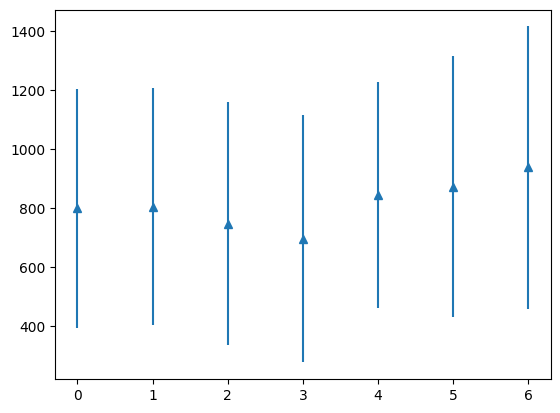

In [17]:
means = []
stds = []
nones = df_trimmed["ORIGIN_CALL"].apply(ogin)
means.append(df_trimmed.loc[nones]['LEN'].mean())
stds.append(df_trimmed.loc[nones]['LEN'].std())
for v in ogcalls:
    print(len(df_trimmed[df_trimmed["ORIGIN_CALL"] == v]))
    means.append(df_trimmed[df_trimmed["ORIGIN_CALL"] == v]["LEN"].mean())
    stds.append(df_trimmed[df_trimmed["ORIGIN_CALL"] == v]["LEN"].std())
plt.errorbar(range(0,7), means, stds, linestyle='None', marker='^')

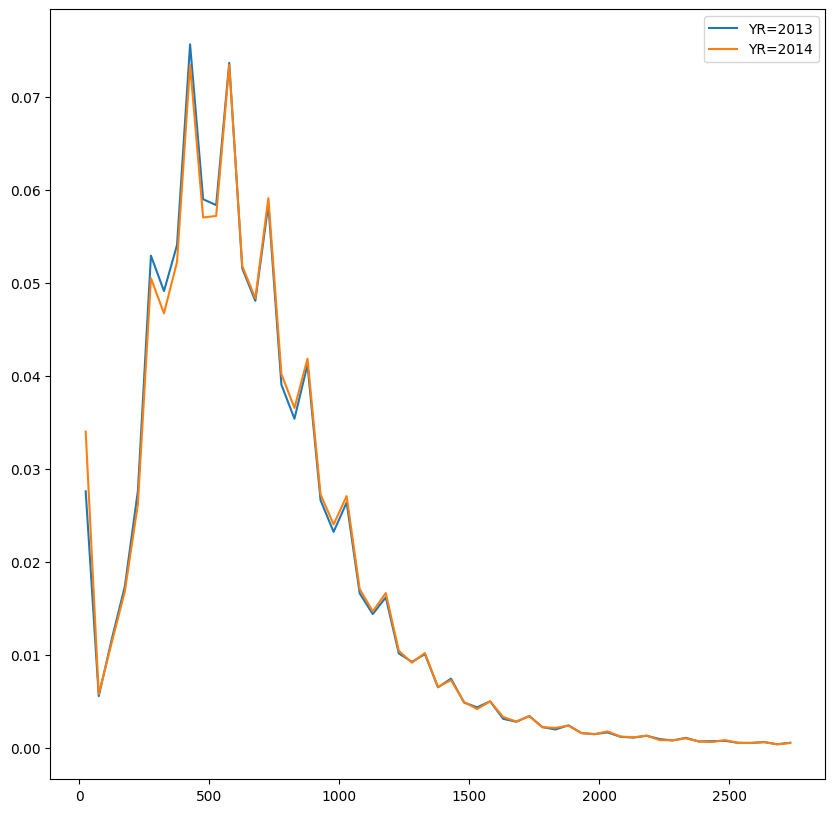

In [18]:
plt.figure(figsize=(10,10))
for v in [2013,2014]:
    # Filter data where the HR matches v
    hourly_data = df_trimmed[df_trimmed["YR"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"YR={v}")
plt.legend();

In [19]:
!pip install holidays
import holidays

In [20]:
from datetime import date

In [21]:
ptholi = holidays.PT()
def ptholiday(x):
    dt = datetime.fromtimestamp(x)
    curr = date(dt.year, dt.month, dt.day)
    if curr in ptholi:
        return 2
    if curr + timedelta(days=1) in ptholi:
        return 1
    else:
        return 0

In [22]:
df_tr['holi']= df_tr['TIMESTAMP'].apply(ptholiday)

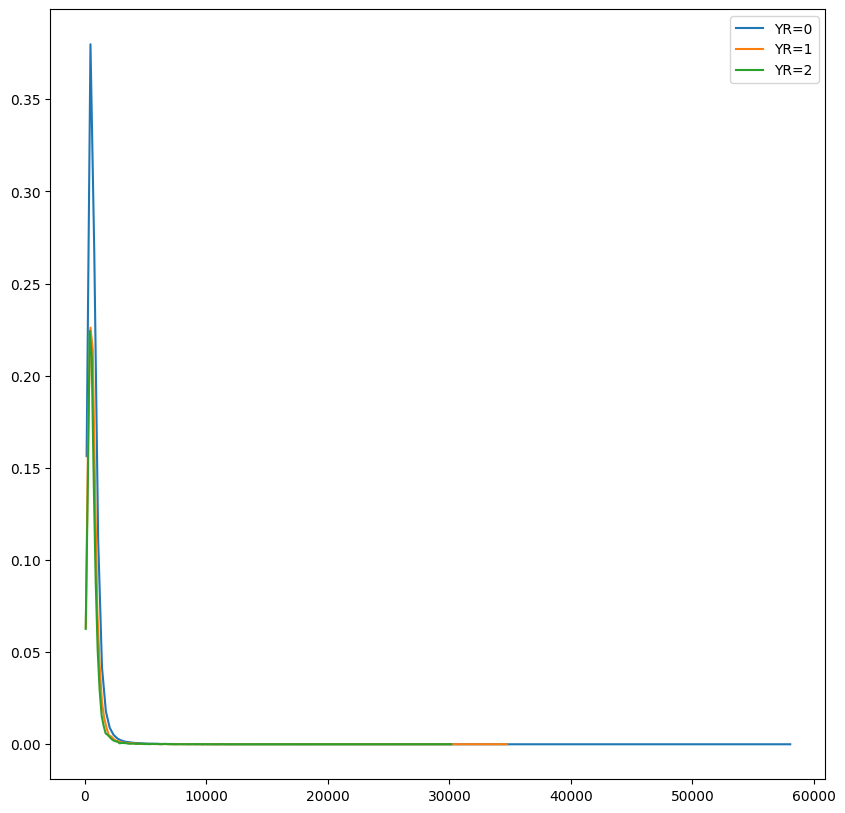

In [23]:
buckets = (int(mean + outlier_threshold * std) // 15)
plt.figure(figsize=(10,10))
for v in [0,1,2]:
    # Filter data where the HR matches v
    hourly_data = df_tr[df_tr["holi"] == v]["LEN"]
    histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
    histogram = histogram / len(hourly_data)
    # The center is the left_bound and right_bound of a bucket
    bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
    plt.plot(bin_centers, histogram, label=f"YR={v}")
plt.legend();

In [ ]:
meta = pd.read_csv("kaggle_data/metaData_taxistandsID_name_GPSlocation.csv")
meta['ID'] = meta["ID"].astype(int)
meta = meta.set_index('ID')
meta.head()

In [ ]:
meta[['Latitude','Longitude']] = meta[['Latitude','Longitude']].astype(float)

In [ ]:
latmean = meta['Latitude'].mean()
lonmean = meta['Longitude'].mean()

In [ ]:
def ogst(x):
    if x.isna().any():
        return latmean, lonmean
    else:
        temp = meta.loc[int(x['ORIGIN_STAND'])]
        return temp['Latitude'], temp['Longitude']

In [ ]:
df_trimmed[["lat",'long']] = df_trimmed[["ORIGIN_STAND"]].apply(ogst, axis=1, result_type="expand")

In [25]:
def fillz(x):
    if x.isna().any():
        return 0
    else:
        return x['ORIGIN_STAND']

In [26]:
df_tr['ORIGIN_STAND'] = df_tr[['ORIGIN_STAND']].apply(fillz, axis=1)

In [27]:
df_trimmed['ORIGIN_STAND'] = df_trimmed[['ORIGIN_STAND']].apply(fillz, axis=1)

C:\Users\sunja\AppData\Local\Temp\ipykernel_16188\2902398729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['ORIGIN_STAND'] = df_trimmed[['ORIGIN_STAND']].apply(fillz, axis=1)


In [191]:
call = []
for i in ogcalls:
    call.append(i)
caenc = OneHotEncoder(handle_unknown='ignore')
caenc.fit(np.array([call]).reshape(-1,1))
call = caenc.categories_
catemp = pd.DataFrame(caenc.transform(df_tr[['ORIGIN_CALL']]).toarray())
catemp.columns = call

C:\Users\sunja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [192]:
catemp

,2001.0,2002.0,5591.0,6728.0,13168.0,63882.0
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1710665,0.0,0.0,0.0,0.0,0.0,0.0
1710666,0.0,0.0,0.0,0.0,0.0,0.0
1710667,0.0,0.0,0.0,0.0,0.0,0.0
1710668,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
df_trimmed['holi']= df_trimmed['TIMESTAMP'].apply(ptholiday)

C:\Users\sunja\AppData\Local\Temp\ipykernel_16188\3108472241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['holi']= df_trimmed['TIMESTAMP'].apply(ptholiday)


In [119]:
df_trimmed.reset_index()[['holi']]

,holi
0,0
1,0
2,0
3,0
4,0
...,...
1692766,0
1692767,0
1692768,0
1692769,0


In [160]:
ogc = []
for i in range(1,64):
    ogc.append(i*1.0)
ogcenc = OneHotEncoder(handle_unknown='ignore')
ogcenc.fit(np.array([ogc]).reshape(-1,1))
ogc = ogcenc.categories_
otemp = pd.DataFrame(ogcenc.transform(df_tr[['ORIGIN_STAND']]).toarray())
otemp.columns = ogc

C:\Users\sunja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [161]:
otemp

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1710666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1710667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1710668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
dayenc = OneHotEncoder()
dayenc.fit(df_trimmed[['WK']])
dats = dayenc.categories_
dtemp = pd.DataFrame(dayenc.transform(df_tr[['WK']]).toarray())
dtemp.columns = dats

In [163]:
dtemp

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1710665,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1710666,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1710667,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1710668,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
monenc = OneHotEncoder()
monenc.fit(df_trimmed[['MON']])
mons = monenc.categories_
mtemp = pd.DataFrame(monenc.transform(df_tr[['MON']]).toarray())
mtemp.columns = mons

In [165]:
mtemp.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
hrenc = OneHotEncoder()
hrenc.fit(df_trimmed[['HR']])
hr = hrenc.categories_
htemp = pd.DataFrame(hrenc.transform(df_tr[['HR']]).toarray())
htemp.columns = hr

In [167]:
htemp.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
callenc = OneHotEncoder()
callenc.fit(df_trimmed[['CALL_TYPE']])
calls = callenc.categories_
ctemp = pd.DataFrame(callenc.transform(df_tr[['CALL_TYPE']]).toarray())
ctemp.columns = calls

In [169]:
ctemp.head()

,A,B,C
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [170]:
yenc = OneHotEncoder()
yenc.fit(df_trimmed[['YR']])
yr = yenc.categories_
ytemp = pd.DataFrame(yenc.transform(df_tr[['YR']]).toarray())
ytemp.columns = yr

In [208]:
X  = df_tr.reset_index()[['holi']]
X = pd.concat([X,catemp,otemp,dtemp,mtemp,htemp,ctemp],axis=1)

In [209]:
X

,holi,"(2001.0,)","(2002.0,)","(5591.0,)","(6728.0,)","(13168.0,)","(63882.0,)","(1.0,)","(2.0,)","(3.0,)",...,"(17,)","(18,)","(19,)","(20,)","(21,)","(22,)","(23,)","(A,)","(B,)","(C,)"
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1710666,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1710667,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1710668,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [210]:
X = X.to_numpy().astype(float)
y = df_tr['LEN'].to_numpy().astype(float)

In [211]:
X.shape

(1710670, 116)

In [212]:
device = torch.device('cuda')

In [213]:
from sklearn.model_selection import train_test_split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [215]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

In [217]:
model = nn.Sequential(
    nn.Linear(116, 256),
    nn.ReLU(),
    #nn.BatchNorm1d(256),
    nn.Dropout(p=0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    #nn.BatchNorm1d(128),
    nn.Dropout(p=0.3),
    nn.Linear(64, 16),
    nn.ReLU(),
    #nn.BatchNorm1d(16),
    nn.Dropout(p=0.3),
    nn.Linear(16, 1),
).to(device)

In [218]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [219]:
n_epochs = 50   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [220]:
save = {'w':None,'history':[],'mse':np.inf}

In [221]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [227]:
for epoch in tqdm.tqdm(range(30)):
    model.train()
    bar = tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True)
    for start in bar:
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
    # evaluate accuracy at end of each epoch
    #scheduler.step()
    with torch.no_grad():
        model.eval()
        train_pred = model(X_train)
        history_train.append(float(loss_fn(train_pred, y_train)))
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history_test.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

100%|████████████████████████| 30/30 [02:55<00:00,  5.84s/it]


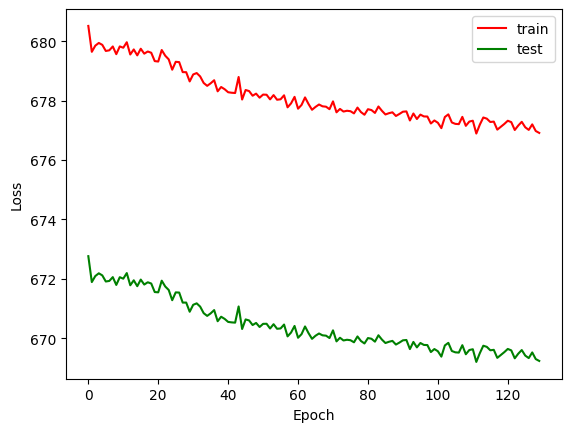

In [228]:
plt.plot(np.sqrt(history_train), color='r', label='train')
plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [144]:
test = pd.read_csv('kaggle_data/test_public.csv')

In [145]:
# test = pd.read_csv('kaggle_data/test_public.csv')
tid = test[['TRIP_ID']]
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [146]:
test['holi']= test['TIMESTAMP'].apply(ptholiday)

In [147]:
test['ORIGIN_STAND'] = test[['ORIGIN_STAND']].apply(fillz, axis=1)

In [79]:
test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,holi
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,10,3,1
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,10,3,1
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,10,3,1
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,10,3,1
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,10,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,0.0,20000430,1419171485,A,False,2014,12,21,6,6,0
316,T324,B,NaN,53.0,20000020,1419170802,A,False,2014,12,21,6,6,0
317,T325,C,NaN,0.0,20000207,1419172121,A,False,2014,12,21,6,6,0
318,T326,A,76232.0,0.0,20000667,1419171980,A,False,2014,12,21,6,6,0


In [150]:
call = caenc.categories_
catest = pd.DataFrame(caenc.transform(test[['ORIGIN_CALL']]).toarray())
catest.columns = call
otest = pd.DataFrame(ogcenc.transform(test[['ORIGIN_STAND']]).toarray())
otest.columns = ogc
dtest = pd.DataFrame(dayenc.transform(test[['WK']]).toarray())
dtest.columns = dats
mtest = pd.DataFrame(monenc.transform(test[['MON']]).toarray())
mtest.columns = mons
htest = pd.DataFrame(hrenc.transform(test[['HR']]).toarray())
htest.columns = hr
ctest = pd.DataFrame(callenc.transform(test[['CALL_TYPE']]).toarray())

C:\Users\sunja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\sunja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [151]:
test = test[['holi']]
test = pd.concat([test,catest,otest,dtest,mtest,htest,ctest],axis=1)

In [152]:
test.head()

,holi,"(2001.0,)","(2002.0,)","(5591.0,)","(6728.0,)","(13168.0,)","(63882.0,)","(1.0,)","(2.0,)","(3.0,)",...,"(17,)","(18,)","(19,)","(20,)","(21,)","(22,)","(23,)",0,1,2
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [153]:
test = test.to_numpy().astype(float)
test = torch.tensor(test, dtype=torch.float32).to(device)

In [75]:
torch.save(best_weights, 'weight.pt')

In [154]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [155]:
with torch.no_grad():
    model.eval()
    pred = model(test)

In [156]:
pred = pred.cpu().detach().numpy().transpose()[0]

In [157]:
tid['TRAVEL_TIME'] = pred

In [158]:
tid

,TRIP_ID,TRAVEL_TIME
0,T1,783.815430
1,T2,672.941284
2,T3,783.815430
3,T4,676.109619
4,T5,727.607056
...,...,...
315,T323,668.297729
316,T324,596.245544
317,T325,654.380493
318,T326,668.297729


In [159]:
tid.to_csv('submission.csv',index=False)